## imports

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os

In [2]:
df_data = pd.read_csv('internet_data.csv', index_col=0)
df_data['tile'] = df_data['tile'].apply(wkt.loads)
df_data = gpd.GeoDataFrame(df_data, geometry='tile')
df_data = df_data.set_crs('epsg:4326')
df_data

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,320102100110313,"POLYGON ((-77.04163 38.80119, -77.03613 38.801...",232107,26768,14,27,10
1,1322122000111322,"POLYGON ((101.57959 13.88608, 101.58508 13.886...",133336,139872,6,85,12
2,233102101021323,"POLYGON ((-99.42078 19.19187, -99.41528 19.191...",31346,11039,11,54,18
3,1202100003203301,"POLYGON ((11.67297 55.44148, 11.67847 55.44148...",292899,157893,8,7,3
4,1231223310210311,"POLYGON ((72.54822 23.05952, 72.55371 23.05952...",54307,45390,9,915,186
...,...,...,...,...,...,...,...
6929479,2110222002030130,"POLYGON ((-44.87915 -19.73568, -44.87366 -19.7...",10553,11544,60,2,1
6929480,1202002320323202,"POLYGON ((1.62598 52.70635, 1.63147 52.70635, ...",3585,14966,39,2,1
6929481,1321222303102333,"POLYGON ((114.47205 22.84201, 114.47754 22.842...",74617,65473,15,1,1
6929482,1233302033113313,"POLYGON ((80.15076 7.29164, 80.15625 7.29164, ...",13558,495,40,4,1


In [3]:
df_ph = pd.read_csv('ph_data.csv', index_col=0)
df_ph['geom'] = df_ph['geom'].apply(wkt.loads)
df_ph = gpd.GeoDataFrame(df_ph, geometry='geom')
df_ph = df_ph.set_crs('epsg:4326')
df_ph

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,Bayan|Munisipyo,Municipality,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.2_1,Boliney,NaN,NaN,Bayan|Munisipyo,Municipality,140102.0,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.3_1,Bucay,NaN,NaN,Bayan|Munisipyo,Municipality,140103.0,PH.AB.BU,"MULTIPOLYGON (((120.70788 17.45395, 120.70621 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.4_1,Bucloc,NaN,NaN,Bayan|Munisipyo,Municipality,140104.0,PH.AB.BC,"MULTIPOLYGON (((120.78956 17.41699, 120.78922 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.5_1,Daguioman,NaN,NaN,Bayan|Munisipyo,Municipality,140105.0,PH.AB.DG,"MULTIPOLYGON (((120.92917 17.41307, 120.92464 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,1640,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.9_1,Naga,NaN,NaN,Bayan|Munisipyo,Municipality,98309.0,PH.ZS.NG,"MULTIPOLYGON (((122.77500 7.76833, 122.77528 7..."
1643,1645,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.14_1,Talusan,NaN,NaN,Bayan|Munisipyo,Municipality,98314.0,PH.ZS.TL,"MULTIPOLYGON (((122.91917 7.34111, 122.91861 7..."
1644,1641,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.10_1,Olutanga,NaN,NaN,Bayan|Munisipyo,Municipality,98310.0,PH.ZS.OU,"MULTIPOLYGON (((122.85805 7.27653, 122.85837 7..."
1645,1642,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.11_1,Payao,NaN,NaN,Bayan|Munisipyo,Municipality,98311.0,PH.ZS.PY,"MULTIPOLYGON (((122.69195 7.46229, 122.69139 7..."


In [4]:
df_merged = gpd.sjoin(df_ph, df_data, how='left', predicate='contains')
df_merged

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,...,cc_2,hasc_2,geom,index_right,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6163299.0,1.323012e+15,2602.0,3440.0,29.0,5.0,2.0
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6619771.0,1.323012e+15,22606.0,51353.0,15.0,1.0,1.0
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6266818.0,1.323012e+15,95567.0,72174.0,19.0,1.0,1.0
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",166904.0,1.323012e+15,53586.0,46808.0,17.0,39.0,7.0
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",684659.0,1.323012e+15,96949.0,90962.0,14.0,20.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,98313.0,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",3886596.0,1.323213e+15,112313.0,178599.0,8.0,1.0,1.0
1646,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,98313.0,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",6659273.0,1.323213e+15,4249.0,1217.0,57.0,14.0,1.0
1646,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,98313.0,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4351320.0,1.323213e+15,799.0,29.0,38.0,1.0,1.0
1646,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,98313.0,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4046898.0,1.323213e+15,62138.0,36609.0,27.0,8.0,2.0


In [5]:
df_conso = pd.merge(df_merged.rename(columns={'index_right':'index'}), df_data.reset_index()[['index','tile']], how='left', on='index')
df_conso

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,...,hasc_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6163299.0,1.323012e+15,2602.0,3440.0,29.0,5.0,2.0,"POLYGON ((120.60791 17.55501, 120.61340 17.555..."
1,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6619771.0,1.323012e+15,22606.0,51353.0,15.0,1.0,1.0,"POLYGON ((120.60791 17.58643, 120.61340 17.586..."
2,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6266818.0,1.323012e+15,95567.0,72174.0,19.0,1.0,1.0,"POLYGON ((120.59692 17.59690, 120.60242 17.596..."
3,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",166904.0,1.323012e+15,53586.0,46808.0,17.0,39.0,7.0,"POLYGON ((120.61340 17.58119, 120.61890 17.581..."
4,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,...,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",684659.0,1.323012e+15,96949.0,90962.0,14.0,20.0,8.0,"POLYGON ((120.61340 17.59167, 120.61890 17.591..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",3886596.0,1.323213e+15,112313.0,178599.0,8.0,1.0,1.0,"POLYGON ((122.88208 7.70010, 122.88757 7.70010..."
77510,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",6659273.0,1.323213e+15,4249.0,1217.0,57.0,14.0,1.0,"POLYGON ((122.84912 7.66744, 122.85461 7.66744..."
77511,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4351320.0,1.323213e+15,799.0,29.0,38.0,1.0,1.0,"POLYGON ((122.87659 7.68377, 122.88208 7.68377..."
77512,1644,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,NaN,PHL.81.13_1,Siay,NaN,NaN,...,PH.ZS.SA,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4046898.0,1.323213e+15,62138.0,36609.0,27.0,8.0,2.0,"POLYGON ((122.88757 7.70010, 122.89307 7.70010..."


In [6]:
df_trim = df_conso.drop(columns=['gid', 'gid_0', 'name_0', 'gid_1', 'nl_name_1', 'gid_2', 'varname_2', 'nl_name_2', 'cc_2', 'hasc_2'])
df_trim

,name_1,name_2,type_2,engtype_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile
0,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6163299.0,1.323012e+15,2602.0,3440.0,29.0,5.0,2.0,"POLYGON ((120.60791 17.55501, 120.61340 17.555..."
1,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6619771.0,1.323012e+15,22606.0,51353.0,15.0,1.0,1.0,"POLYGON ((120.60791 17.58643, 120.61340 17.586..."
2,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",6266818.0,1.323012e+15,95567.0,72174.0,19.0,1.0,1.0,"POLYGON ((120.59692 17.59690, 120.60242 17.596..."
3,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",166904.0,1.323012e+15,53586.0,46808.0,17.0,39.0,7.0,"POLYGON ((120.61340 17.58119, 120.61890 17.581..."
4,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",684659.0,1.323012e+15,96949.0,90962.0,14.0,20.0,8.0,"POLYGON ((120.61340 17.59167, 120.61890 17.591..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,Zamboanga Sibugay,Siay,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",3886596.0,1.323213e+15,112313.0,178599.0,8.0,1.0,1.0,"POLYGON ((122.88208 7.70010, 122.88757 7.70010..."
77510,Zamboanga Sibugay,Siay,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",6659273.0,1.323213e+15,4249.0,1217.0,57.0,14.0,1.0,"POLYGON ((122.84912 7.66744, 122.85461 7.66744..."
77511,Zamboanga Sibugay,Siay,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4351320.0,1.323213e+15,799.0,29.0,38.0,1.0,1.0,"POLYGON ((122.87659 7.68377, 122.88208 7.68377..."
77512,Zamboanga Sibugay,Siay,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((122.81555 7.72806, 122.81500 7...",4046898.0,1.323213e+15,62138.0,36609.0,27.0,8.0,2.0,"POLYGON ((122.88757 7.70010, 122.89307 7.70010..."


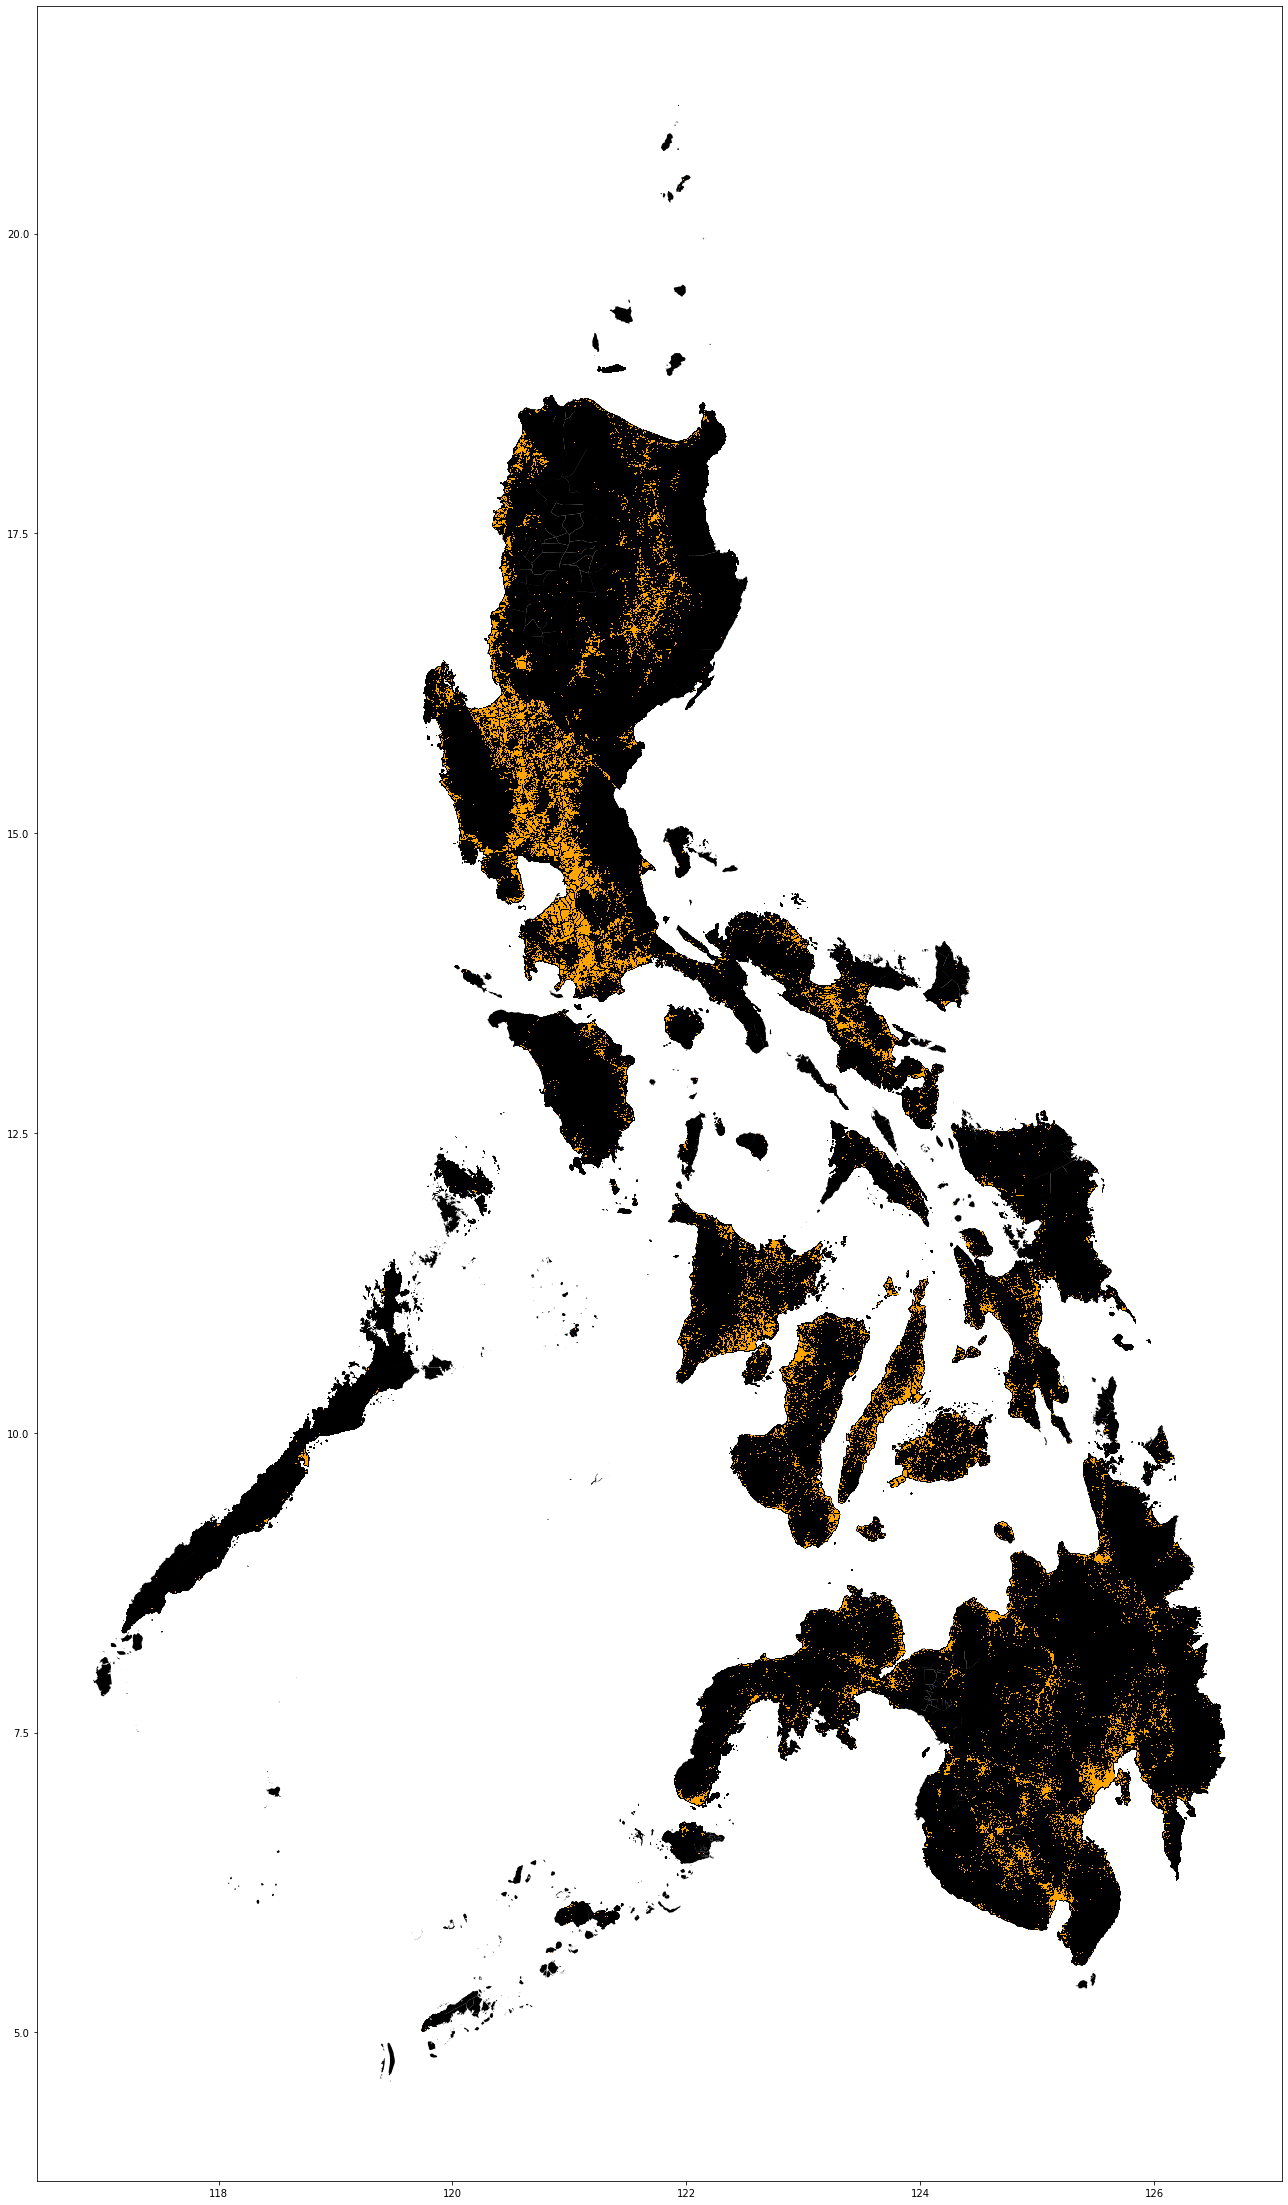

In [7]:
fig, ax = plt.subplots(figsize=(50,40))
df_trim['geom'].plot(ax=ax, color='black')
df_trim['tile'].plot(ax=ax, color='orange')
plt.savefig('ph')

# filtering manila

In [8]:
df_mm = df_trim[df_trim['name_1']=='Metropolitan Manila']
df_mm

,name_1,name_2,type_2,engtype_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile
43982,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",36370.0,1.323031e+15,77094.0,84609.0,8.0,3775.0,692.0,"POLYGON ((121.06384 14.54637, 121.06934 14.546..."
43983,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",94071.0,1.323031e+15,81364.0,83144.0,5.0,3439.0,604.0,"POLYGON ((121.06934 14.55168, 121.07483 14.551..."
43984,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",170253.0,1.323031e+15,75314.0,67335.0,6.0,926.0,185.0,"POLYGON ((121.04736 14.72707, 121.05286 14.727..."
43985,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",2515.0,1.323031e+15,55798.0,49012.0,7.0,1612.0,340.0,"POLYGON ((121.04187 14.72707, 121.04736 14.727..."
43986,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",417961.0,1.323031e+15,80762.0,70718.0,9.0,247.0,86.0,"POLYGON ((121.05286 14.72707, 121.05835 14.727..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45294,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",176685.0,1.323031e+15,69291.0,67368.0,6.0,1376.0,314.0,"POLYGON ((120.98694 14.68457, 120.99243 14.684..."
45295,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",37396.0,1.323031e+15,68750.0,69533.0,6.0,1271.0,277.0,"POLYGON ((120.98145 14.68457, 120.98694 14.684..."
45296,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",344841.0,1.323031e+15,62021.0,60313.0,6.0,916.0,183.0,"POLYGON ((120.97046 14.68457, 120.97595 14.684..."
45297,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",103345.0,1.323031e+15,79729.0,82733.0,6.0,1080.0,253.0,"POLYGON ((120.97595 14.68457, 120.98145 14.684..."


In [9]:
df_pop = pd.read_csv('financial_pop.csv')
df_mm= df_mm.merge(df_pop, left_on = ['name_1','name_2'],
                       right_on = ['shp_province','shp_municipality'])
df_mm

,name_1,name_2,type_2,engtype_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,...,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",36370.0,1.323031e+15,77094.0,84609.0,8.0,...,56.080847,201.599229,163.300161,38.299068,0.000000,1.482140,4.546140,62.811989,Metropolitan Manila,Pateros
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",94071.0,1.323031e+15,81364.0,83144.0,5.0,...,56.080847,201.599229,163.300161,38.299068,0.000000,1.482140,4.546140,62.811989,Metropolitan Manila,Pateros
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",170253.0,1.323031e+15,75314.0,67335.0,6.0,...,12833.213830,18526.608000,9782.849320,8743.758684,0.000000,4860.912186,4860.912186,12761.512750,Metropolitan Manila,Quezon City
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",2515.0,1.323031e+15,55798.0,49012.0,7.0,...,12833.213830,18526.608000,9782.849320,8743.758684,0.000000,4860.912186,4860.912186,12761.512750,Metropolitan Manila,Quezon City
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",417961.0,1.323031e+15,80762.0,70718.0,9.0,...,12833.213830,18526.608000,9782.849320,8743.758684,0.000000,4860.912186,4860.912186,12761.512750,Metropolitan Manila,Quezon City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",176685.0,1.323031e+15,69291.0,67368.0,6.0,...,2326.883631,3600.962103,2900.140827,700.821275,282.242568,194.692661,582.015924,476.726565,Metropolitan Manila,Valenzuela
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",37396.0,1.323031e+15,68750.0,69533.0,6.0,...,2326.883631,3600.962103,2900.140827,700.821275,282.242568,194.692661,582.015924,476.726565,Metropolitan Manila,Valenzuela
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",344841.0,1.323031e+15,62021.0,60313.0,6.0,...,2326.883631,3600.962103,2900.140827,700.821275,282.242568,194.692661,582.015924,476.726565,Metropolitan Manila,Valenzuela
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",103345.0,1.323031e+15,79729.0,82733.0,6.0,...,2326.883631,3600.962103,2900.140827,700.821275,282.242568,194.692661,582.015924,476.726565,Metropolitan Manila,Valenzuela


In [10]:
df_pop[['pop', 'net_oper_income', 'shp_municipality']]

,pop,net_oper_income,shp_municipality
0,48163.0,23.728359,Bangued
1,3573.0,2.279973,Boliney
2,17115.0,27.424853,Bucay
3,2501.0,15.155923,Bucloc
4,2088.0,3.393836,Daguioman
...,...,...,...
1622,NaN,49.091008,Tinambac
1623,NaN,9.121061,Camaligan
1624,NaN,44.616059,Lagonoy
1625,NaN,34.253516,Balatan


## plotting manila with tiles

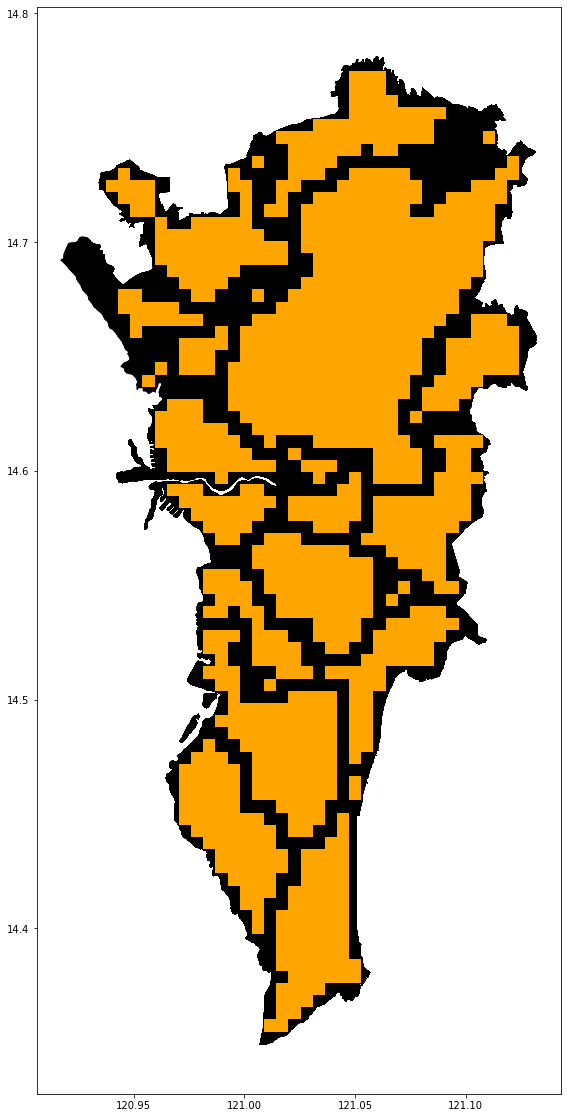

In [11]:
fig, ax = plt.subplots(figsize=(30,20))

df_mm['geom'].plot(ax=ax, color='black')
df_mm['tile'].plot(ax=ax, color='orange')
plt.savefig('metromanila')

In [12]:
df_mm.columns

Index(['name_1', 'name_2', 'type_2', 'engtype_2', 'geom', 'index', 'quadkey',
       'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'tile',
       'pop', 'tot_local_sources', 'tot_tax_revenue',
       'tot_current_oper_income', 'total_oper_expenses', 'net_oper_income',
       'total_non_income_receipts', 'capital_expenditure',
       'total_non_oper_expenditures', 'cash_balance_end', 'shp_province',
       'shp_municipality'],
      dtype='object')

In [13]:
df_mm.drop(columns=['index', 
                    'tot_local_sources', 
                    'tot_tax_revenue', 
                    'tot_current_oper_income', 
                    'total_oper_expenses', 
                    'total_non_income_receipts', 
                    'capital_expenditure',
                    'total_non_oper_expenditures', 
                    'cash_balance_end', 'quadkey'], inplace=True)
df_mm

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile,pop,net_oper_income,shp_province,shp_municipality
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,"POLYGON ((121.06384 14.54637, 121.06934 14.546...",63840.0,38.299068,Metropolitan Manila,Pateros
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,"POLYGON ((121.06934 14.55168, 121.07483 14.551...",63840.0,38.299068,Metropolitan Manila,Pateros
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,"POLYGON ((121.04736 14.72707, 121.05286 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",55798.0,49012.0,7.0,1612.0,340.0,"POLYGON ((121.04187 14.72707, 121.04736 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",80762.0,70718.0,9.0,247.0,86.0,"POLYGON ((121.05286 14.72707, 121.05835 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,"POLYGON ((120.98694 14.68457, 120.99243 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,"POLYGON ((120.98145 14.68457, 120.98694 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,"POLYGON ((120.97046 14.68457, 120.97595 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,"POLYGON ((120.97595 14.68457, 120.98145 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela


In [14]:
df_mm['tile_number'] = range(1, df_mm.shape[0]+1)
df_mm

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile,pop,net_oper_income,shp_province,shp_municipality,tile_number
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,"POLYGON ((121.06384 14.54637, 121.06934 14.546...",63840.0,38.299068,Metropolitan Manila,Pateros,1
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,"POLYGON ((121.06934 14.55168, 121.07483 14.551...",63840.0,38.299068,Metropolitan Manila,Pateros,2
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,"POLYGON ((121.04736 14.72707, 121.05286 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City,3
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",55798.0,49012.0,7.0,1612.0,340.0,"POLYGON ((121.04187 14.72707, 121.04736 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City,4
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",80762.0,70718.0,9.0,247.0,86.0,"POLYGON ((121.05286 14.72707, 121.05835 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,"POLYGON ((120.98694 14.68457, 120.99243 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela,1037
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,"POLYGON ((120.98145 14.68457, 120.98694 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela,1038
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,"POLYGON ((120.97046 14.68457, 120.97595 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela,1039
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,"POLYGON ((120.97595 14.68457, 120.98145 14.684...",620422.0,700.821275,Metropolitan Manila,Valenzuela,1040


In [15]:
df_mm.head(3)

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile,pop,net_oper_income,shp_province,shp_municipality,tile_number
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,"POLYGON ((121.06384 14.54637, 121.06934 14.546...",63840.0,38.299068,Metropolitan Manila,Pateros,1
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,"POLYGON ((121.06934 14.55168, 121.07483 14.551...",63840.0,38.299068,Metropolitan Manila,Pateros,2
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,"POLYGON ((121.04736 14.72707, 121.05286 14.727...",2936116.0,8743.758684,Metropolitan Manila,Quezon City,3


In [16]:
df_absow = pd.read_csv('amen_bldg_shop_off_way.csv', index_col=0)
df_absow

,amenity,building,shop,office,way
0,place_of_worship,NaN,NaN,NaN,POINT (121.0650407 14.5397932)
1,NaN,NaN,NaN,NaN,POINT (121.0656832 14.5397264)
2,nightclub,NaN,NaN,NaN,POINT (121.0673295 14.5396869)
3,NaN,NaN,car_parts,NaN,POINT (121.067403 14.5400665)
4,NaN,NaN,NaN,NaN,POINT (121.067423 14.5401178)
...,...,...,...,...,...
41106,shelter,NaN,NaN,NaN,POINT (121.0115863 14.7372878)
41107,NaN,NaN,NaN,NaN,POINT (121.0137322 14.7358747)
41108,NaN,NaN,NaN,NaN,POINT (121.0133435 14.7366616)
41109,school,NaN,NaN,NaN,POINT (121.011909 14.739541)


In [17]:
def get_total_and_counts(df_absow, col_name, pref):
    df_amen = df_absow[[col_name, 'way']].copy().dropna()
    df_amen['way'] = df_amen['way'].copy().apply(wkt.loads)
    df_amen = gpd.GeoDataFrame(df_amen, geometry='way', crs=4326)
    df_try = gpd.sjoin(gpd.GeoDataFrame(df_mm, geometry='tile'), df_amen, predicate='contains', how='left')
    total_count = df_try.groupby('tile_number')[col_name].count().reset_index().rename(columns={col_name:f'{col_name}_count'})
    def point_counter(df_try, point_col, prefix):    
        from collections import Counter
        df_amen_counter = pd.DataFrame()
        for i in tqdm.notebook.tqdm(df_try.tile_number.unique()):
            dict_ = Counter(df_try[df_try.tile_number==i][point_col])


            prefix_dict = {}
            for key, val in dict_.items():
                prefix_dict[f'{prefix}_{key}'] = val
            prefix_dict['tile_number'] = i
            df_amen_counter = df_amen_counter.append(prefix_dict, ignore_index=True)
        return df_amen_counter

    amenities = point_counter(df_try, col_name, pref)
    df_total_and_counts = pd.merge(total_count, amenities, on='tile_number')
    return df_total_and_counts

In [18]:
amen = get_total_and_counts(df_absow, 'amenity', 'amen')
amen

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,amenity_count,amen_restaurant,amen_fast_food,amen_school,amen_bank,amen_place_of_worship,amen_clinic,amen_tricycle_station,amen_fuel,...,amen_ktv,"amen_McKinley Hill, Taguig",amen_car_service,amen_internet,amen_hardware_store,amen_animal_boarding,amen_atm;fountain,amen_hackerspace,amen_emergency_service,amen_generic building
0,1,32,5.0,6.0,3.0,9.0,3.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6,NaN,1.0,1.0,2.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,2,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,14,2.0,1.0,NaN,8.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
building = get_total_and_counts(df_absow, 'building', 'bldg')
building

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,building_count,bldg_nan,bldg_yes,bldg_university,bldg_hangar,bldg_house,bldg_commercial,bldg_residential,bldg_mosque,...,bldg_retail,bldg_roof,bldg_dormitory,bldg_public,bldg_warehouse,bldg_store,bldg_construction,bldg_garage,"bldg_East Tower, Philippine Stock Exchange","bldg_West Tower, Philippine Stock Exchange"
0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
office = get_total_and_counts(df_absow, 'office', 'ofc')
office

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,office_count,ofc_nan,ofc_government,ofc_company,ofc_accountant,ofc_yes,ofc_lawyer,ofc_employment_agency,ofc_it,...,ofc_telecommunication,ofc_school,ofc_advertising_agency,ofc_architect,ofc_political_party,ofc_construction_company,ofc_water_utility,ofc_publisher,ofc_Flcapili and Associates - 4092 Airport Road Baclaran Parañaque,ofc_administrative
0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
shop = get_total_and_counts(df_absow, 'shop', 'shp')
shop

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,shop_count,shp_convenience,shp_supermarket,shp_car_parts,shp_hardware,shp_optician,shp_bicycle,shp_car,shp_electronics,...,shp_office_supplies,shp_junkyard,shp_printhouse,shp_fabric,shp_water_station,shp_business_services,shp_printing,shp_travel_agent,shp_ASCI,shp_antiques
0,1,23,4.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_mm_amen = pd.merge(df_mm, amen, on='tile_number')
df_mm_amen_off = pd.merge(df_mm_amen, office, on='tile_number')
df_mm_amen_off_shp = pd.merge(df_mm_amen_off, shop, on='tile_number')
df_mm_amen_off_shp_bldg = pd.merge(df_mm_amen_off_shp, building, on='tile_number')
df_mm_amen_off_shp_bldg

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,...,bldg_retail,bldg_roof,bldg_dormitory,bldg_public,bldg_warehouse,bldg_store,bldg_construction,bldg_garage,"bldg_East Tower, Philippine Stock Exchange","bldg_West Tower, Philippine Stock Exchange"
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",55798.0,49012.0,7.0,1612.0,340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",80762.0,70718.0,9.0,247.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
############ viz for amenities and tiles
# fig, ax = plt.subplots(figsize=(20,15))
# gpd.GeoDataFrame(df_mm[['tile', 'tile_number']], geometry='tile').plot(ax=ax, edgecolor='red', color='black')
# df_amen.plot(ax=ax, edgecolor='white', markersize=3, color='blue')

In [24]:
df_data.columns

Index(['quadkey', 'tile', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests',
       'devices'],
      dtype='object')

# Encoding

In [25]:
df_ML = pd.concat([df_mm_amen_off_shp_bldg, pd.get_dummies(df_mm_amen_off_shp_bldg['name_2'])], axis=1)
df_ML

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,...,Muntinlupa,Navotas,Parañaque,Pasay City,Pasig City,Pateros,Quezon City,San Juan,Taguig,Valenzuela
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,...,0,0,0,0,0,1,0,0,0,0
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,...,0,0,0,0,0,1,0,0,0,0
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,...,0,0,0,0,0,0,1,0,0,0
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",55798.0,49012.0,7.0,1612.0,340.0,...,0,0,0,0,0,0,1,0,0,0
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",80762.0,70718.0,9.0,247.0,86.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,...,0,0,0,0,0,0,0,0,0,1
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,...,0,0,0,0,0,0,0,0,0,1
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,...,0,0,0,0,0,0,0,0,0,1
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
df_diss = df_ML[['name_2', 'geom']].dissolve('name_2')
df_diss

,geom
name_2,
Kalookan City,"MULTIPOLYGON (((120.98671 14.63653, 120.98495 ..."
Las Piñas,"MULTIPOLYGON (((120.99373 14.41066, 120.99380 ..."
Makati City,"POLYGON ((121.06578 14.53872, 121.06594 14.538..."
Malabon,"POLYGON ((120.95800 14.65938, 120.95796 14.658..."
Mandaluyong,"POLYGON ((121.05405 14.57747, 121.05408 14.577..."
Manila,"POLYGON ((120.99142 14.56218, 120.98849 14.561..."
Marikina,"POLYGON ((121.07346 14.61962, 121.07432 14.620..."
Muntinlupa,"POLYGON ((121.02339 14.35760, 121.02313 14.357..."
Navotas,"POLYGON ((120.96163 14.63365, 120.96139 14.633..."


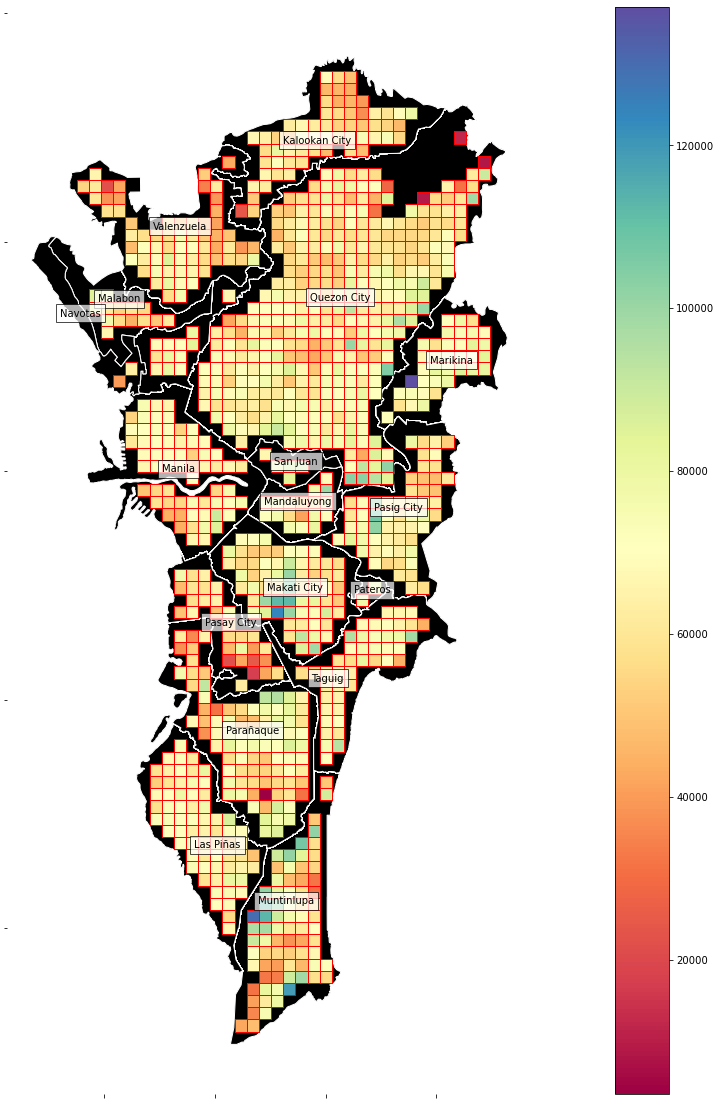

In [27]:
fig, ax = plt.subplots(figsize=(30,20))
df_diss['coords'] = df_diss['geom'].apply(lambda x: x.representative_point().coords[:])
df_diss['coords'] = [coords[0] for coords in df_diss['coords']]
for idx, row in df_diss.iterrows():
    plt.annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='black', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
gpd.GeoDataFrame(df_ML, geometry='geom').plot(ax=ax, edgecolor='white', color='black')
gpd.GeoDataFrame(df_ML, geometry='tile').plot(ax=ax, edgecolor='red', column='avg_d_kbps', cmap='Spectral', legend=True)
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('tiles.png')

In [31]:
df_ML.drop(columns='tile')[['name_2','geom', 'avg_d_kbps']].dissolve('name_2', aggfunc='mean').mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


avg_d_kbps    66414.930204
dtype: float64

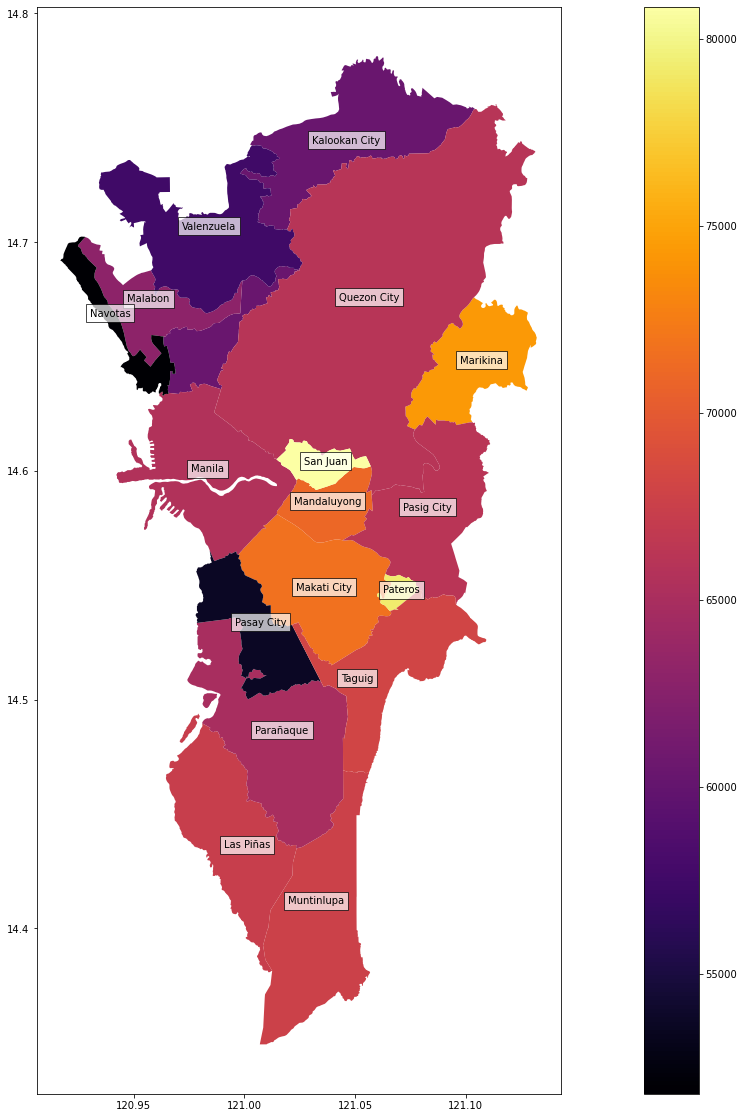

In [29]:
fig, ax = plt.subplots(figsize=(30,20))
gpd.GeoDataFrame(df_ML.drop(columns='tile')[['name_2','geom', 'avg_d_kbps']].dissolve('name_2', aggfunc='mean'), geometry='geom').plot(ax=ax, column='avg_d_kbps', cmap='inferno', legend=True)
for idx, row in df_diss.iterrows():
    plt.annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='black', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
plt.savefig('download_avg.png')

# ML

## Splitting

In [150]:
X = df_ML[df_ML.columns.difference(['name_1', 'name_2', 'type_2', 'engtype_2',
                                    'geom', 'shp_province', 'shp_municipality',
                                    'avg_u_kbps', 'tile', 'avg_lat_ms', 'quadkey',
                                    'avg_d_kbps', 'tile_number', 'amen_nan', 'ofc_nan', 'bldg_nan', 'shp_nan', 'devices', 'tests'])]
y = df_ML['avg_d_kbps']

In [151]:
X.fillna(0, inplace=True)
# X.isna().sum().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [152]:
y

0       77094.0
1       81364.0
2       75314.0
3       55798.0
4       80762.0
         ...   
1036    69291.0
1037    68750.0
1038    62021.0
1039    79729.0
1040    21799.0
Name: avg_d_kbps, Length: 1041, dtype: float64

In [300]:
y[X.Navotas.apply(lambda x: True if x==1 else False)]

747    40114.0
748    63471.0
Name: avg_d_kbps, dtype: float64

In [154]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

## XGBoost

In [249]:
def tune_XGBoost(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 2,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        # Classifier definition
        model = xgb.XGBRegressor(seed=20, **param)

                
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

In [250]:
xgb_study, xgb_optimize = tune_XGBoost(X_trainval, y_trainval)

[I 2021-12-08 00:56:11,998] A new study created in memory with name: no-name-68fd1da5-6fca-4fc7-80c0-b36625aa1e81
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-08 00:56:14,317] Trial 3 finished with value: 12290.062164463143 and parameters: {'lambda': 3.37525498321749, 'alpha': 0.11415168819603197, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.013715157748369589, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 115}. Best is trial 3 with value: 12290.062164463143.
[I 2021-12-08 00:56:14,877] Trial 4 finished with value: 10373.253946314104 and parameters: {'lambda': 0.00303566691205852, 'alpha': 2.4622636737434487, 'colsample_bytree': 0.8, 'subsample': 0.3, 'learning_rate': 0.1699148354478627, 'n_estimators': 20, 'max_depth': 2, 'min_child_weight': 170}. Best is trial 4 with value: 10373.253946314104.
[I 2021-12-08 00:56:17,472] Trial 0 finished with v

In [253]:
xgb_study.best_params

{'lambda': 0.025349186700583212,
 'alpha': 0.004520545463948247,
 'colsample_bytree': 0.6000000000000001,
 'subsample': 0.3,
 'learning_rate': 0.01254364673805459,
 'n_estimators': 460,
 'max_depth': 14,
 'min_child_weight': 10}

In [254]:
xgb_study.best_value

9784.599634415064

In [255]:
xgb_study.best_trial.number

783

In [256]:
def testing_optimal_model(model, n_trials):

    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
       


        mae = mean_absolute_error(y_val, y_pred)
    
        
        mae_list.append(mae)
    return np.mean(mae_list), mae_list

In [269]:
xgb_model = xgb.XGBRegressor(seed=20, **xgb_study.best_params)
xgb_test_mae, xgb_mae_list = testing_optimal_model(xgb_model, 20)
xgb_test_mae
# 4234

  0%|          | 0/20 [00:00<?, ?it/s]

10279.971395324475

## GBM

In [251]:
def tune_GBM(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate, random_state=11)

        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
    
    
        
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

In [252]:
gbm_study, gbm_optimize = tune_GBM(X_trainval, y_trainval)

[I 2021-12-08 01:54:53,501] A new study created in memory with name: no-name-cc9fa489-8acf-4c8c-b997-d697ca0790ff
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-08 01:55:05,887] Trial 3 finished with value: 10434.372077165623 and parameters: {'n_estimators': 60, 'max_depth': 27, 'max_features': 354, 'learning_rate': 0.017212687059989917}. Best is trial 3 with value: 10434.372077165623.
[I 2021-12-08 01:55:06,159] Trial 0 finished with value: 10400.035541661346 and parameters: {'n_estimators': 150, 'max_depth': 78, 'max_features': 100, 'learning_rate': 0.0807407717916744}. Best is trial 0 with value: 10400.035541661346.
[I 2021-12-08 01:55:06,612] Trial 1 finished with value: 10719.70808999027 and parameters: {'n_estimators': 450, 'max_depth': 8, 'max_features': 71, 'learning_rate': 0.08349382359528794}. Best is trial 0 with value: 10400.035541661346.
[I 2021-12-08 01:55:11,098

In [258]:
display(gbm_study.best_trial)
display(gbm_study.best_value)
display(gbm_study.best_params)

FrozenTrial(number=743, values=[9775.039344742103], datetime_start=datetime.datetime(2021, 12, 8, 2, 13, 5, 857802), datetime_complete=datetime.datetime(2021, 12, 8, 2, 13, 7, 480164), params={'n_estimators': 180, 'max_depth': 9, 'max_features': 16, 'learning_rate': 0.01880504951595134}, distributions={'n_estimators': IntUniformDistribution(high=800, low=10, step=10), 'max_depth': IntUniformDistribution(high=100, low=2, step=1), 'max_features': IntUniformDistribution(high=375, low=2, step=1), 'learning_rate': UniformDistribution(high=0.1, low=1e-06)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=743, state=TrialState.COMPLETE, value=None)

9775.039344742103

{'n_estimators': 180,
 'max_depth': 9,
 'max_features': 16,
 'learning_rate': 0.01880504951595134}

In [259]:
gbm_model = GradientBoostingRegressor(random_state=11, **gbm_study.best_params)
gbm_test_mae, gbm_mae_list = testing_optimal_model(gbm_model, 20)
gbm_test_mae
# 4234

  0%|          | 0/20 [00:00<?, ?it/s]

10160.358877139168

## Random Forest

In [260]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import KFold
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features, random_state=11)
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

In [261]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-12-08 02:17:35,554] A new study created in memory with name: no-name-297af688-3d46-4554-8546-8ba314f74be0
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-08 02:17:36,578] Trial 3 finished with value: 10279.611237878602 and parameters: {'n_estimators': 10, 'max_depth': 15, 'max_features': 139}. Best is trial 3 with value: 10279.611237878602.
[I 2021-12-08 02:17:51,517] Trial 4 finished with value: 10081.297060242985 and parameters: {'n_estimators': 330, 'max_depth': 51, 'max_features': 182}. Best is trial 4 with value: 10081.297060242985.
[I 2021-12-08 02:17:52,090] Trial 2 finished with value: 10137.947171986501 and parameters: {'n_estimators': 240, 'max_depth': 75, 'max_features': 320}. Best is trial 4 with value: 10081.297060242985.
[I 2021-12-08 02:17:57,800] Trial 5 finished with value: 10053.933127605704 and parameters: {'n_estimators': 70, 'max_depth': 75, 'max_fe

In [262]:
display(rf_study.best_trial)
display(rf_study.best_value)
display(rf_study.best_params)

FrozenTrial(number=579, values=[9811.194089984301], datetime_start=datetime.datetime(2021, 12, 8, 2, 42, 29, 661652), datetime_complete=datetime.datetime(2021, 12, 8, 2, 42, 40, 62610), params={'n_estimators': 330, 'max_depth': 14, 'max_features': 39}, distributions={'n_estimators': IntUniformDistribution(high=500, low=10, step=10), 'max_depth': IntUniformDistribution(high=100, low=2, step=1), 'max_features': IntUniformDistribution(high=375, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=579, state=TrialState.COMPLETE, value=None)

9811.194089984301

{'n_estimators': 330, 'max_depth': 14, 'max_features': 39}

In [263]:
rf_model = RandomForestRegressor(random_state=11, **rf_study.best_params)
rf_test_mae, rf_mae_list = testing_optimal_model(rf_model, 20)
rf_test_mae

  0%|          | 0/20 [00:00<?, ?it/s]

10139.164070770263

In [171]:
X.columns.tolist()

['Kalookan City',
 'Las Piñas',
 'Makati City',
 'Malabon',
 'Mandaluyong',
 'Manila',
 'Marikina',
 'Muntinlupa',
 'Navotas',
 'Parañaque',
 'Pasay City',
 'Pasig City',
 'Pateros',
 'Quezon City',
 'San Juan',
 'Taguig',
 'Valenzuela',
 'amen_BPI ATM',
 'amen_Highway',
 'amen_McKinley Hill, Taguig',
 'amen_Uload Phils',
 'amen_adult_gaming_centre',
 'amen_airline_office',
 'amen_animal_boarding',
 'amen_arcade',
 'amen_arts_centre',
 'amen_atm',
 'amen_atm;fountain',
 'amen_bank',
 'amen_bank;restaurant',
 'amen_bar',
 'amen_bar;restaurant',
 'amen_bbq',
 'amen_bench',
 'amen_bicycle_parking',
 'amen_bicycle_rental',
 'amen_bicycle_repair_station',
 'amen_biergarten',
 'amen_building',
 'amen_bureau_de_change',
 'amen_bus_station',
 'amen_bus_stop',
 'amen_cafe',
 'amen_car_rental',
 'amen_car_service',
 'amen_car_sharing',
 'amen_car_wash',
 'amen_casino',
 'amen_charging_station',
 'amen_childcare',
 'amen_cinema',
 'amen_clinic',
 'amen_clock',
 'amen_college',
 'amen_commercial',

## KNN

In [264]:
def tune_KNN(X, y):
    
    def optimize(trial):
        # Definition of space search
        n_neighbors = trial.suggest_int('n_neighbors', 2, 300, step=10)
        
        
        # Classifier definition
        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

In [265]:
knn_study, knn_optimize = tune_KNN(X_trainval, y_trainval)

[I 2021-12-08 03:00:21,226] A new study created in memory with name: no-name-909cb174-3cf3-4bb1-8e50-938b50ce12a3
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-08 03:00:22,023] Trial 2 finished with value: 13082.759615384615 and parameters: {'n_neighbors': 2}. Best is trial 2 with value: 13082.759615384615.
The distribution is specified by [2, 300] and step=10, but 

In [266]:
display(knn_study.best_trial)
display(knn_study.best_value)
display(knn_study.best_params)

FrozenTrial(number=18, values=[10144.403943701225], datetime_start=datetime.datetime(2021, 12, 8, 3, 0, 25, 338279), datetime_complete=datetime.datetime(2021, 12, 8, 3, 0, 26, 436237), params={'n_neighbors': 92}, distributions={'n_neighbors': IntUniformDistribution(high=292, low=2, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)

10144.403943701225

{'n_neighbors': 92}

In [267]:
knn_model = KNeighborsRegressor(**knn_study.best_params)
knn_test_mae, knn_mae_list = testing_optimal_model(knn_model, 20)
knn_test_mae

  0%|          | 0/20 [00:00<?, ?it/s]

10761.456888222554

## ML Summary

In [270]:
df_ml_summary = pd.DataFrame([[xgb_test_mae, xgb_study.best_value][::-1],
              [rf_test_mae, rf_study.best_value][::-1],
              [gbm_test_mae, gbm_study.best_value][::-1],
              [knn_test_mae, knn_study.best_value][::-1],
              ], 
             index=['XGBoost', 'Random Forest', 'GBM', 'KNN'],
             columns=['Avg Test MAE', 'Avg Val MAE'][::-1]
             )
df_ml_summary

,Avg Val MAE,Avg Test MAE
XGBoost,9784.599634,10279.971395
Random Forest,9811.194090,10139.164071
GBM,9775.039345,10160.358877
KNN,10144.403944,10761.456888


# SHAP on XGboost

In [271]:
np.argmin(rf_mae_list)

0

In [272]:
(X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                      random_state=0, 
                                                      test_size=0.25)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_val_scaled)



mae = mean_absolute_error(y_val, y_pred)
mae

9474.420591813065

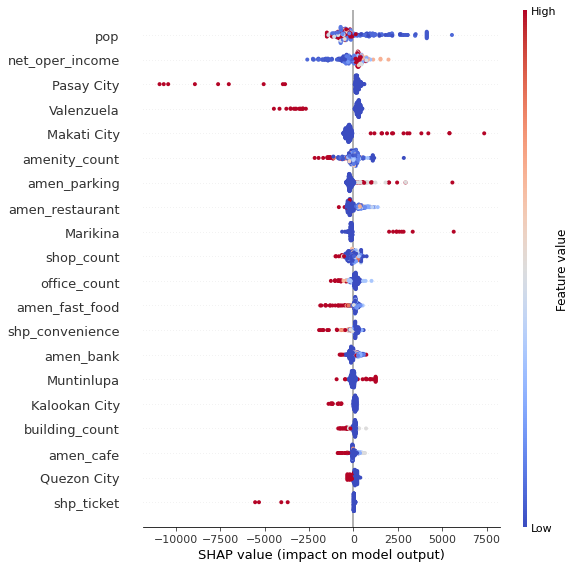

In [308]:
explainer_xgb = shap.TreeExplainer(rf_model)
shap_values = explainer_xgb.shap_values(X_val_scaled)
shap.summary_plot(shap_values = shap_values, features = X_val_scaled, 
                  feature_names=X_val.columns,
                  max_display=20, cmap='coolwarm', show=False)
plt.savefig('beeswarm.png')

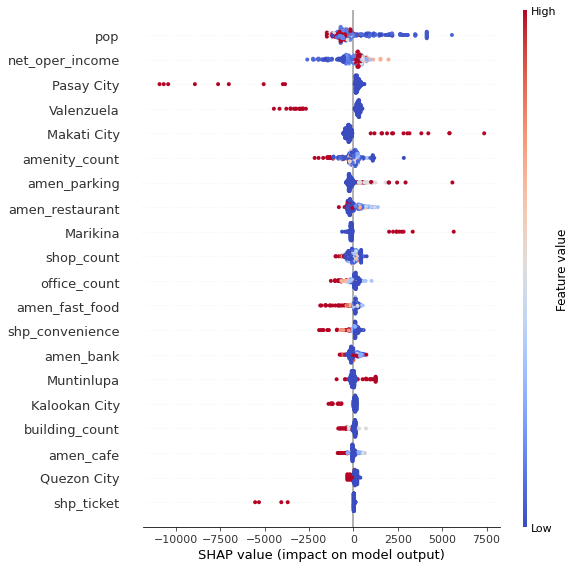

,Kalookan City,Las Piñas,Makati City,Malabon,Mandaluyong,Manila,Marikina,Muntinlupa,Navotas,Parañaque,...,shp_various,shp_video,shp_vulcanizing,shp_watch,shp_water,shp_water_station,shp_weapons,shp_wine,shp_wine;alcohol,shp_yes
976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


X has feature names, but RandomForestRegressor was fitted without feature names


array([58711.71607789])

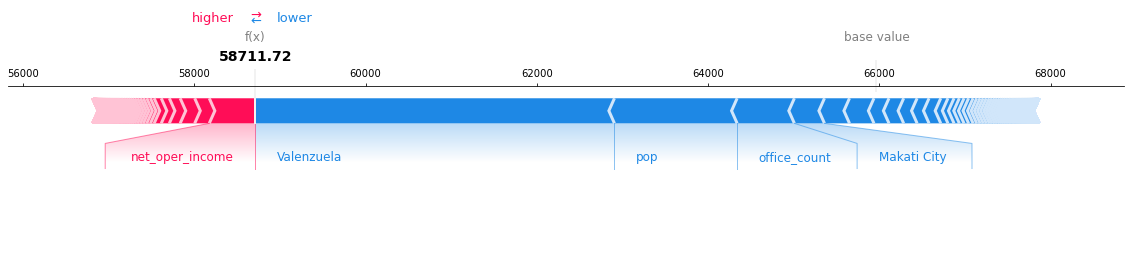

In [311]:

display(rf_model.predict(X[X['Valenzuela']==1].loc[976,:].to_frame().T))
explainer_xgb = shap.TreeExplainer(rf_model)
shap_values = explainer_xgb.shap_values(X[X['Valenzuela']==1].loc[976,:].to_frame().T)
shap.force_plot(explainer_xgb.expected_value, 
                shap_values, X.columns, matplotlib=True)

,Kalookan City,Las Piñas,Makati City,Malabon,Mandaluyong,Manila,Marikina,Muntinlupa,Navotas,Parañaque,...,shp_various,shp_video,shp_vulcanizing,shp_watch,shp_water,shp_water_station,shp_weapons,shp_wine,shp_wine;alcohol,shp_yes
668,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [301]:

shap.force_plot?

Signature:
shap.force_plot(
    base_value,
    shap_values=None,
    features=None,
    feature_names=None,
    out_names=None,
    link='identity',
    plot_cmap='RdBu',
    matplotlib=False,
    show=True,
    figsize=(20, 3),
    ordering_keys=None,
    ordering_keys_time_format=None,
    text_rotation=0,
    contribution_threshold=0.05,
)
Docstring:
Visualize the given SHAP values with an additive force layout.

Parameters
----------
base_value : float
    This is the reference value that the feature contributions start from. For SHAP values it should
    be the value of explainer.expected_value.

shap_values : numpy.array
    Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
    force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.

features : numpy.array
    Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
    features, and should be the same s